In [1]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Bibliotecas

In [2]:
!pip install aeon
!pip install folium
!pip install dtwalign
!pip install fastdtw
!pip install dtaidistance
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tempfile
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from fastdtw import fastdtw
from dtwalign import dtw
import matplotlib.pyplot as pl
from dtaidistance import dtw
from aeon.distances import dtw_distance
from aeon.distances import euclidean_distance
from aeon.distances import dtw_pairwise_distance
from scipy.spatial.distance import euclidean, cityblock, chebyshev, canberra, mahalanobis
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import inv
from scipy.cluster.hierarchy import fcluster

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score
import geopandas as gpd
import pandas as pd
import plotly.express as px

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512552 sha256=957f99eb1b0166de4439ba7aa02f7421259c397a2b0d5a796c0c1bcd752bbb28
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.3 MB/s eta 0:00:00


## Banco de dados

In [3]:
directory = "/content/drive/MyDrive/preprocessed/"

# Cria um dicionário para armazenar os dataframes
df_dict = {}

# Percorre todos os arquivos na pasta
for filename in os.listdir(directory):
  if filename.endswith(".xlsx"):
    # Remove a extensão '.xlsx' para usar como nome da chave
    well_name = os.path.splitext(filename)[0]
    df_dict[well_name] = pd.read_excel(os.path.join(directory, filename)).drop(["Unnamed: 0"], axis=1)


## Padronização dos dados

In [4]:

standardized_dict = {}

for filename in os.listdir(directory):
  if filename.endswith(".xlsx"):
    well_name = os.path.splitext(filename)[0]

    df = pd.read_excel(os.path.join(directory, filename)).drop(["Unnamed: 0"], axis=1)

    # Converte o dataframe para numpy e padroniza com StandardScaler
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df.values)

    # Armazena a matriz padronizada no dicionário
    standardized_dict[well_name] = standardized_data

# Exibindo um exemplo de poço padronizado
for well_name, data in standardized_dict.items():
  print(f"Matriz padronizada do poço {well_name}:\n", data)
  break  # Remova este break para exibir todas as matrizes

Matriz padronizada do poço 1-BRSA-470D-BA:
 [[-1.73186245 -1.5729034  -0.87341354  1.741093    2.50968108  1.98139695]
 [-1.73148571 -1.48178335 -0.87341354  1.741093    2.50968108  1.98139695]
 [-1.73110897 -1.38216276 -0.87341354  1.96611181  2.50968108  1.98139695]
 ...
 [ 1.73110897 -1.50896064 -2.39107374 -1.31916284  1.96062769 -1.20495442]
 [ 1.73148571 -1.50896064 -2.39434351 -1.31916284  1.93874347 -1.20495442]
 [ 1.73186245 -1.50896064 -2.40067545 -1.31916284  1.84390144 -1.20495442]]


## Análise de Componentes Principais

In [5]:
# Definindo as colunas específicas para as variáveis desejadas
colunas_variaveis = ['PROF (m)', 'GR (api)', 'RHO (g/cc)', 'PHI (dec)', 'PE (b/e)', 'DT (uspf)']

# Dicionários para armazenar dados
final_data_dict_PCA1 = {}
pca1_loadings_PCA1 = {}
explained_variance_dict_PCA1 = {}

for well_name, data in standardized_dict.items():
    # Seleciona as primeiras 6 colunas da matriz padronizada
    data_matrix = np.array(data)[:, :6]
    df = pd.DataFrame(data_matrix, columns=colunas_variaveis)

    # Seleciona as variáveis explicativas
    X = df[['GR (api)', 'RHO (g/cc)', 'PHI (dec)', 'PE (b/e)', 'DT (uspf)']]

    # Calcula o PCA para as variáveis explicativas
    pca = PCA(n_components=1)
    pca1_component = pca.fit_transform(X)[:, 0]

    # Adiciona o PCA1 ao DataFrame e salva no dicionário
    df['PCA1'] = pca1_component
    final_data_dict_PCA1[well_name] = df
    pca1_loadings_PCA1[well_name] = pca.components_[0]  # Loadings do PCA1

    # Armazena a variabilidade explicada pelo PCA1
    explained_variance_ratio = pca.explained_variance_ratio_[0]
    explained_variance_dict_PCA1[well_name] = explained_variance_ratio

    # Exibe os valores do PCA1 e a variabilidade explicada para cada poço
    print(f"\nPoço: {well_name}")
    print(f"Variabilidade explicada pelo PCA1: {explained_variance_ratio * 100:.2f}%")
    print("Valores do PCA1 para cada observação:")
    print(df[['PROF (m)', 'GR (api)', 'RHO (g/cc)', 'PHI (dec)', 'PE (b/e)', 'DT (uspf)', 'PCA1']].head())

    # Exibe os loadings para identificar a contribuição de cada variável
    loadings = pca.components_[0]  # Loadings do PCA1
    loadings_df = pd.DataFrame(loadings, index=['GR (api)', 'RHO (g/cc)', 'PHI (dec)', 'PE (b/e)', 'DT (uspf)'], columns=['Loading'])

    # Ordena por valor absoluto dos loadings para encontrar o maior peso
    loadings_df['Abs_Loading'] = loadings_df['Loading'].abs()
    print("Loadings do PCA1 (incluindo magnitudes absolutas):")
    print(loadings_df.round(4))

    # Identificando a variável com maior peso (em valor absoluto)
    maior_peso_var = loadings_df['Abs_Loading'].idxmax()
    print(f"A variável com maior peso no PCA1 é: {maior_peso_var} com um valor absoluto de {loadings_df.loc[maior_peso_var, 'Abs_Loading']:.4f}")

# Consolidar os loadings de todos os poços em um único DataFrame
all_loadings_df = pd.DataFrame.from_dict(pca1_loadings_PCA1, orient='index', columns=['GR (api)', 'RHO (g/cc)', 'PHI (dec)', 'PE (b/e)', 'DT (uspf)'])
print("\nLoadings consolidados de todos os poços:")
print(all_loadings_df)


Poço: 1-BRSA-470D-BA
Variabilidade explicada pelo PCA1: 39.71%
Valores do PCA1 para cada observação:
   PROF (m)  GR (api)  RHO (g/cc)  PHI (dec)  PE (b/e)  DT (uspf)      PCA1
0 -1.731862 -1.572903   -0.873414   1.741093  2.509681   1.981397  3.043324
1 -1.731486 -1.481783   -0.873414   1.741093  2.509681   1.981397  3.048437
2 -1.731109 -1.382163   -0.873414   1.966112  2.509681   1.981397  3.200480
3 -1.730732 -1.371768   -0.873414   1.989592  2.509681   1.981397  3.216345
4 -1.730355 -1.153742   -0.873414   1.912303  2.509681   1.981397  3.178275
Loadings do PCA1 (incluindo magnitudes absolutas):
            Loading  Abs_Loading
GR (api)     0.0561       0.0561
RHO (g/cc)   0.2822       0.2822
PHI (dec)    0.6508       0.6508
PE (b/e)     0.5341       0.5341
DT (uspf)    0.4564       0.4564
A variável com maior peso no PCA1 é: PHI (dec) com um valor absoluto de 0.6508

Poço: 1-OGX-117-MA
Variabilidade explicada pelo PCA1: 52.35%
Valores do PCA1 para cada observação:
   PROF (m)  G

## DWT Intrapoços

In [6]:

# Seleciona os 16 primeiros poços no dicionário
poco_aeon = list(final_data_dict_PCA1.keys())

for well_name in poco_aeon:
    # Seleciona a planilha do poço atual
    df = final_data_dict_PCA1[well_name]

    # Extrai as séries PROF (m) e PCA1
    prof_series = df['PROF (m)'].values  # Série de referência
    pca1_series = df['PCA1'].values      # Série de comparação

    # Define o tamanho da janela como uma proporção (10% do comprimento da série)
    window_size = 0.10  # 10% de janela

    # Calcula a distância DTW entre PROF (m) e PCA1 com a janela especificada
    dtw_distance_value = dtw_distance(prof_series, pca1_series, window=window_size)

    # Exibe o resultado
    print(f"Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '{well_name}': {dtw_distance_value:.4f}")


Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '1-BRSA-470D-BA': 38388.9124
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '1-OGX-117-MA': 33323.6892
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1057D': 27490.6129
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1093-SE': 18986.3536
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1121-AM': 40670.1053
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1193-RN': 27055.9140
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1210-RN': 25295.9493
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1224-RN': 16958.2989
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1262-SE': 6593.2042
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1279-SE': 13534.7273
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1295-RN': 20904.6868
Distância DTW (aeon) entre PROF (m) e PCA1 para o poço '3-BRSA-1307D-SE': 17423.3

## Distância eucliana

In [7]:


# Seleciona os 16 primeiros poços no dicionário
poco_aeon = list(final_data_dict_PCA1.keys())

for well_name in poco_aeon:
    # Seleciona a planilha do poço atual
    df = final_data_dict_PCA1[well_name]

    # Extrai as séries PROF (m) e PCA1
    prof_series = df['PROF (m)'].values  # Série de referência
    pca1_series = df['PCA1'].values      # Série de comparação

    # Calcula a distância Euclidiana entre PROF (m) e PCA1
    euclidean_distance_value = euclidean_distance(prof_series, pca1_series)

    # Exibe o resultado
    print(f"Distância Euclidiana entre PROF (m) e PCA1 para o poço '{well_name}': {euclidean_distance_value:.4f}")


Distância Euclidiana entre PROF (m) e PCA1 para o poço '1-BRSA-470D-BA': 202.7921
Distância Euclidiana entre PROF (m) e PCA1 para o poço '1-OGX-117-MA': 204.0601
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1057D': 176.6713
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1093-SE': 154.5402
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1121-AM': 220.3225
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1193-RN': 174.7061
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1210-RN': 174.5484
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1224-RN': 138.6419
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1262-SE': 93.1953
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1279-SE': 121.9255
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1295-RN': 157.8127
Distância Euclidiana entre PROF (m) e PCA1 para o poço '3-BRSA-1307D-SE': 145.8190
Distância Euclidiana

## DTW Interpoços

In [8]:


def dtw_pairwise_matrix_pca1(final_data_dict_PCA1):

    # Lista de nomes dos poços
    well_names = list(final_data_dict_PCA1.keys())

    # Extrai as séries PCA1 como uma lista de arrays
    pca1_series = [final_data_dict_PCA1[well]['PCA1'].values for well in well_names]

    # Calcula a matriz de dissimilaridade DTW
    dist_matrix = dtw_pairwise_distance(pca1_series)

    # Converte a matriz para um DataFrame para facilitar a análise
    dissimilarity_df = pd.DataFrame(dist_matrix, index=well_names, columns=well_names)
    return dissimilarity_df


In [9]:
dissimilarity_dtw_pca1 = dtw_pairwise_matrix_pca1(final_data_dict_PCA1)

# Exibe a matriz de dissimilaridade
print("Matriz de Dissimilaridade com DTW (PCA1):")
print(dissimilarity_dtw_pca1)


Matriz de Dissimilaridade com DTW (PCA1):
                 1-BRSA-470D-BA  1-OGX-117-MA  3-BRSA-1057D  3-BRSA-1093-SE  \
1-BRSA-470D-BA         0.000000  22493.424475   1689.562990     3776.004362   
1-OGX-117-MA       22493.424475      0.000000  13760.854340     6998.764936   
3-BRSA-1057D        1689.562990  13760.854340      0.000000     2275.233499   
3-BRSA-1093-SE      3776.004362   6998.764936   2275.233499        0.000000   
3-BRSA-1121-AM     19490.666044  13020.309463  16076.244557    10079.629803   
3-BRSA-1193-RN     10123.176319   7277.658947   8167.497567     6053.078760   
3-BRSA-1210-RN      7443.949350   7241.045854   5406.480445     2899.107670   
3-BRSA-1224-RN      3264.221715  27886.876482   3659.883195     5607.887578   
3-BRSA-1262-SE     21056.417569   3376.595209  13479.744933     8493.804356   
3-BRSA-1279-SE      4006.475701  12313.233639   3010.015317     2369.383966   
3-BRSA-1295-RN     14580.882738   6650.105601  10191.298143     4675.956607   
3-BRSA-130

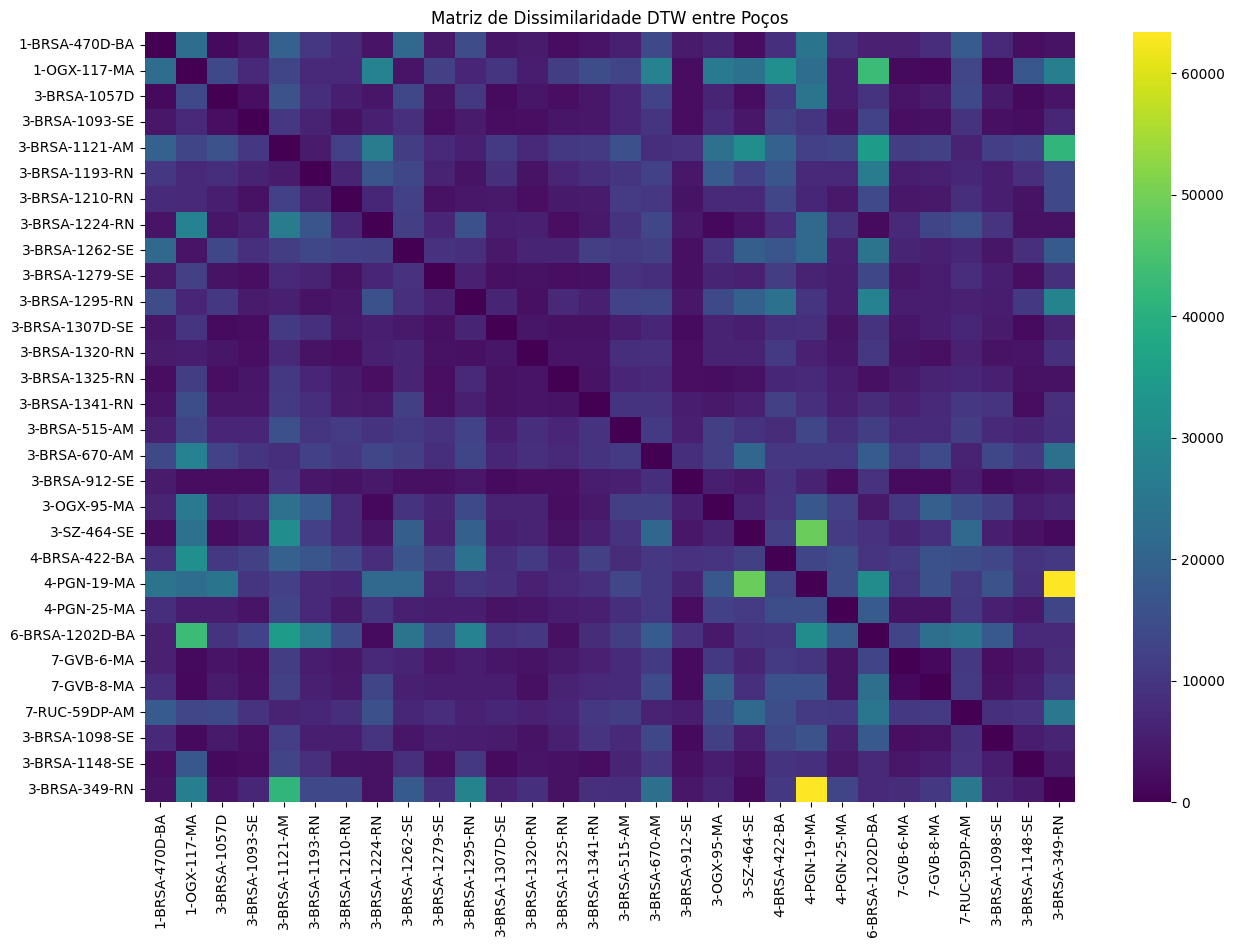

In [10]:
plt.figure(figsize=(15, 10))
# Heatmap para PCA1
sns.heatmap(dissimilarity_dtw_pca1, xticklabels=True, yticklabels=True, cmap="viridis")
plt.title("Matriz de Dissimilaridade DTW entre Poços")

# Salvar a figura
plt.savefig('heatmap_dissimilarity_dtw.png', dpi=300, bbox_inches='tight')

# Exibir a figura
plt.show()


## Agrupamento do interpoços

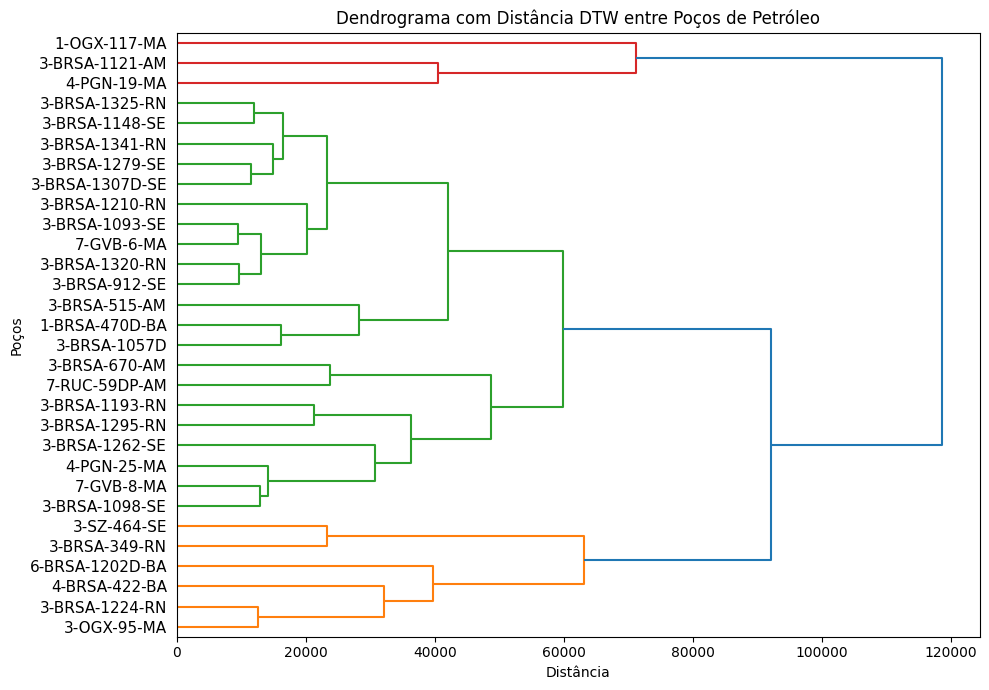

In [11]:
# Realizar o linkage usando a matriz de distância DTW
well_names = list(final_data_dict_PCA1.keys())  # Final_data_dict_PCA1 contém os nomes dos poços
Z_dtw_PCA1 = hierarchy.linkage(dissimilarity_dtw_pca1, method='complete')

# Criar o dendrograma
plt.figure(figsize=(10, 7))
hierarchy.dendrogram(
    Z_dtw_PCA1,
    orientation='right',
    labels=well_names,
    distance_sort='descending',
    leaf_font_size=11
)
plt.title("Dendrograma com Distância DTW entre Poços de Petróleo")
plt.xlabel("Distância")
plt.ylabel("Poços")
plt.tight_layout()

# Salvar a figura
plt.savefig('dendrograma_dtw.png', dpi=300, bbox_inches='tight')

# Exibir a figura
plt.show()


In [12]:


# Número de clusters desejado
num_clusters = 3

# Gerar os clusters a partir do linkage
clusters = fcluster(Z_dtw_PCA1, t=num_clusters, criterion='maxclust')

# Exibir os clusters atribuídos
print(f"Clusters atribuídos aos poços: {clusters}")




Clusters atribuídos aos poços: [2 1 2 2 1 2 2 3 2 2 2 2 2 2 2 2 2 2 3 3 3 1 2 3 2 2 2 2 2 3]


In [13]:
poços_clusters = list(zip(well_names, clusters))
for poço, cluster in poços_clusters:
    print(f"Poço: {poço}, Cluster: {cluster}")


Poço: 1-BRSA-470D-BA, Cluster: 2
Poço: 1-OGX-117-MA, Cluster: 1
Poço: 3-BRSA-1057D, Cluster: 2
Poço: 3-BRSA-1093-SE, Cluster: 2
Poço: 3-BRSA-1121-AM, Cluster: 1
Poço: 3-BRSA-1193-RN, Cluster: 2
Poço: 3-BRSA-1210-RN, Cluster: 2
Poço: 3-BRSA-1224-RN, Cluster: 3
Poço: 3-BRSA-1262-SE, Cluster: 2
Poço: 3-BRSA-1279-SE, Cluster: 2
Poço: 3-BRSA-1295-RN, Cluster: 2
Poço: 3-BRSA-1307D-SE, Cluster: 2
Poço: 3-BRSA-1320-RN, Cluster: 2
Poço: 3-BRSA-1325-RN, Cluster: 2
Poço: 3-BRSA-1341-RN, Cluster: 2
Poço: 3-BRSA-515-AM, Cluster: 2
Poço: 3-BRSA-670-AM, Cluster: 2
Poço: 3-BRSA-912-SE, Cluster: 2
Poço: 3-OGX-95-MA, Cluster: 3
Poço: 3-SZ-464-SE, Cluster: 3
Poço: 4-BRSA-422-BA, Cluster: 3
Poço: 4-PGN-19-MA, Cluster: 1
Poço: 4-PGN-25-MA, Cluster: 2
Poço: 6-BRSA-1202D-BA, Cluster: 3
Poço: 7-GVB-6-MA, Cluster: 2
Poço: 7-GVB-8-MA, Cluster: 2
Poço: 7-RUC-59DP-AM, Cluster: 2
Poço: 3-BRSA-1098-SE, Cluster: 2
Poço: 3-BRSA-1148-SE, Cluster: 2
Poço: 3-BRSA-349-RN, Cluster: 3


## Validação do modelo

In [14]:

# Calcular a matriz de linkage usando o método 'complete'
Z_complete = linkage(dissimilarity_dtw_pca1, method='complete')

# Calcular o coeficiente cophenético
coph_corr_complete, _ = cophenet(Z_complete, pdist(dissimilarity_dtw_pca1))

# Imprimir o resultado
print(f"Método: complete, Coeficiente cophenético: {coph_corr_complete:.3f}")




Método: complete, Coeficiente cophenético: 0.807


In [15]:
from sklearn.metrics import silhouette_score

# Calcular o índice de silhueta
silhouette_avg = silhouette_score(dissimilarity_dtw_pca1, clusters, metric="precomputed")
print(f"Índice de Silhueta: {silhouette_avg}")


Índice de Silhueta: 0.20917764652879747


In [24]:
import geopandas as gpd
import pandas as pd
import plotly.express as px

# Caminho para o shapefile
shapefile_path = '/content/drive/MyDrive/POCOS_SIRGAS/POCOS_SIRGASPoint.shp'

# Lista dos poços e clusters atualizados
poços_clusters = [
    ('1-BRSA-470D-BA', 2), ('1-OGX-117-MA', 1), ('3-BRSA-1057D', 2), ('3-BRSA-1093-SE', 2),
    ('3-BRSA-1121-AM', 1), ('3-BRSA-1193-RN', 2), ('3-BRSA-1210-RN', 2), ('3-BRSA-1224-RN', 3),
    ('3-BRSA-1262-SE', 2), ('3-BRSA-1279-SE', 2), ('3-BRSA-1295-RN', 2), ('3-BRSA-1307D-SE', 2),
    ('3-BRSA-1320-RN', 2), ('3-BRSA-1325-RN', 2), ('3-BRSA-1341-RN', 2), ('3-BRSA-515-AM', 2),
    ('3-BRSA-670-AM', 2), ('3-BRSA-912-SE', 2), ('3-OGX-95-MA', 3), ('3-SZ-464-SE', 3),
    ('4-BRSA-422-BA', 3), ('4-PGN-19-MA', 1), ('4-PGN-25-MA', 2), ('6-BRSA-1202D-BA', 3),
    ('7-GVB-6-MA', 2), ('7-GVB-8-MA', 2), ('7-RUC-59DP-AM', 2), ('3-BRSA-1098-SE', 2),
    ('3-BRSA-1148-SE', 2), ('3-BRSA-349-RN', 3)
]

# Carregar o shapefile
gdf = gpd.read_file(shapefile_path, encoding='latin1')

# Criar DataFrame com os poços e clusters atualizados
df_clusters = pd.DataFrame(poços_clusters, columns=['POCO', 'Cluster'])

# Substituir nomes inconsistentes no shapefile
gdf['POCO'] = gdf['POCO'].replace({
    '3-BRSA-1057D-AM': '3-BRSA-1057D',
    '3-SZ-46-SE': '3-SZ-464-SE'
})

# Combinar os clusters com o shapefile
gdf_merged = gdf.merge(df_clusters, on='POCO', how='inner')

# Adicionar coordenadas
gdf_merged['Longitude'] = gdf_merged.geometry.x
gdf_merged['Latitude'] = gdf_merged.geometry.y

# Criar o mapa interativo com cores únicas para cada cluster
fig = px.scatter_mapbox(
    gdf_merged,
    lat='Latitude',
    lon='Longitude',
    color='Cluster',
    hover_name='POCO',
    labels={'Cluster': 'Cluster'},
    color_discrete_map={
        1: "#FF4500",  # Laranja avermelhado (Cluster 1)
        2: "#1E90FF",  # Azul Dodger (Cluster 2)
        3: "#32CD32"   # Verde limão (Cluster 3)
    },
    mapbox_style="carto-positron",
    zoom=3.2,
    center={"lat": -14.2350, "lon": -51.9253},
    height=900
)

# Ajustar o layout para centralizar e adicionar a legenda
fig.update_layout(
    title={
        'text': "Clusters dos Poços no Mapa do Brasil",
        'x': 0.5,  # Centralizar o título
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}  # Aumentar o tamanho do título
    },
    legend=dict(
        title="Legenda",
        itemsizing="constant",
        orientation="h",  # Colocar a legenda na horizontal
        x=0.5,
        xanchor="center",
        y=-0.1,
        yanchor="top"
    ),
    margin={"r": 0, "t": 50, "l": 0, "b": 0}  # Ajustar margens
)

# Adicionar a barra de cores para melhor visualização
fig.update_coloraxes(colorbar=dict(
    title="Clusters",
    tickvals=[1, 2, 3],  # Apenas valores dos clusters
    ticktext=['Cluster 1', 'Cluster 2', 'Cluster 3']  # Rótulos para a legenda
))

# Mostrar o mapa
fig.show()





In [17]:
# Salvar o gráfico interativo como um arquivo HTML
fig.write_html("mapa_clusters.html", auto_open=False)

# Confirmar que o mapa foi salvo
print("O mapa foi salvo como 'mapa_clusters.html'.")



O mapa foi salvo como 'mapa_clusters.html'.
